In [14]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev = qml.device('default.mixed', wires = 1)

# Hamiltonian setup 
coeffs = [-0.5]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

In [15]:
# Global paras 
Tau_global = 5e-2   # Dephase tau
# Tau_global = 1e-100   # Dephase tau
Paras_global, Phi_global, Gamma_ps  = np.zeros(2), 0, 0

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

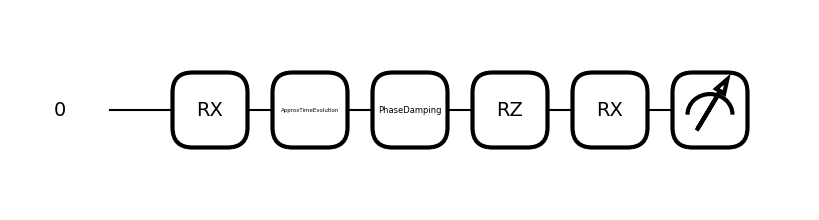

In [16]:
@qml.qnode(dev)
def circuit(paras):
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = paras[0], paras[1]

    qml.RX(np.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)


@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

In [17]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [18]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    """ Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        Sweep_Data (numpy_array): Range of data sweeps.
        paras (numpy_array): Array of 3 parameters for the qnode.
        gamma_ps_select (int): The Gamma value for post-selection.
        Iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array
    """
    
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # INDEX CONSTANT
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Before optimization; CFI data
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
        for Paras_Index_Array in range(len(paras)):
            Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
        
    # Optimize begin
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            Constraints = [(-float('inf'), float('inf'))] * 2 
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'L-BFGS-B', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

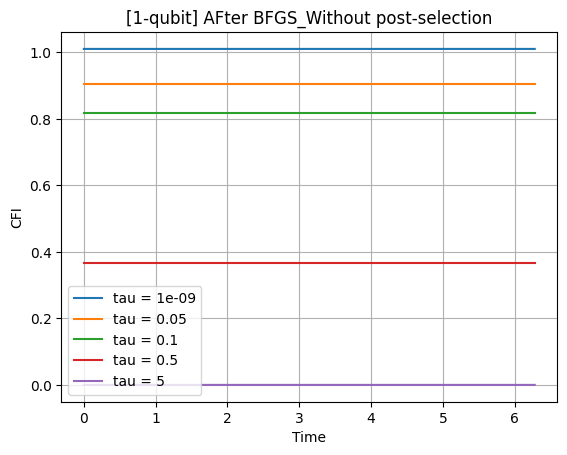

In [19]:
tau_plot = 1e-09, 5e-2, 1e-1, 5e-1, 5
Sweep_data = np_.array([1e-4, np.pi * 2 + 1e-4, 1e-2])

Sweep_data_arange = np_.arange(Sweep_data[0], Sweep_data[1], Sweep_data[2])

Para_store = np.zeros((len(tau_plot), len(Sweep_data_arange), 2))

for i in range(len(tau_plot)):
    Tau_global = tau_plot[i]
    
    Paras_init = np.zeros(2)
    Paras_init[:2] = np.pi/2

    Gamma_ps_preset = 1e-2
    Set_Iterations = 1

    Optimized_Result = BFGS(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)
    
    Para_store[i][:, 0] = Optimized_Result[1][:,2]
    Para_store[i][:, 1] = Optimized_Result[1][:,3]
    
    # plt.plot(Sweep_data_arange, Optimized_Result[0][:, 1], label = f'Before_tau = {tau_plot[i]}')
    plt.plot(Sweep_data_arange, Optimized_Result[1][:, 1], label = f'tau = {tau_plot[i]}')
    plt.title(f'[1-qubit] AFter BFGS_Without post-selection')
    
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

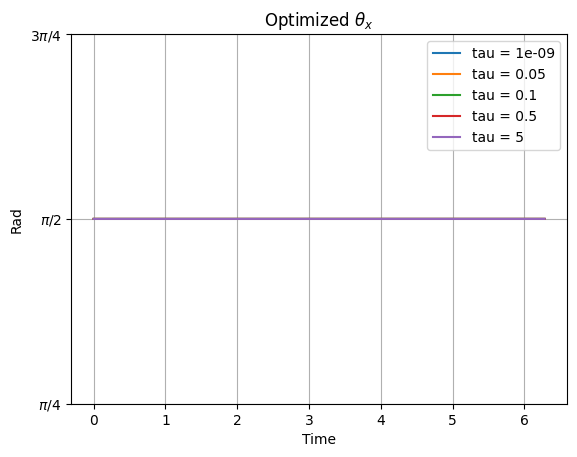

In [20]:
for i in range(0, len(tau_plot)):
    plt.plot(Sweep_data_arange, Para_store[i][:, 0], label = f'tau = {tau_plot[i]}')

# Set the yticks to be at π/4, π/2, and 3π/4
plt.yticks([np.pi/4, np.pi/2, 3*np.pi/4], ['$\pi/4$', '$\pi/2$', '$3\pi/4$'])

plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

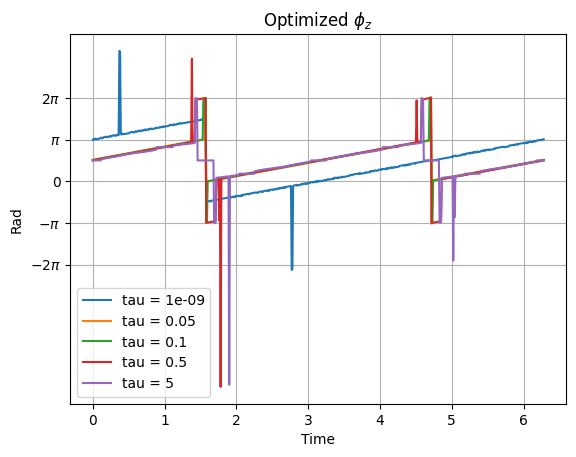

In [26]:
for i in range(0, len(tau_plot)):
    # if i != 1:
        plt.plot(Sweep_data_arange, Para_store[i][:, 1], label = f'tau = {tau_plot[i]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi], ['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

In [31]:
np.pi*1e-2

0.031415926535897934

In [22]:
Para_store[0][:,0]

tensor([1.57079408, 1.57079797, 1.5707955 , 1.57079576, 1.57079375,
        1.57079732, 1.57079633, 1.57081502, 1.57079741, 1.57079599,
        1.57079734, 1.57079662, 1.57079516, 1.57079698, 1.57079635,
        1.57079943, 1.57079771, 1.57079492, 1.57079824, 1.57079781,
        1.57079658, 1.57079637, 1.57079597, 1.57079738, 1.5707958 ,
        1.57079626, 1.57079752, 1.57079635, 1.5707965 , 1.5707962 ,
        1.57079623, 1.57079631, 1.57079624, 1.57079525, 1.5707956 ,
        1.57079752, 1.57079634, 1.57079612, 1.57079632, 1.57079703,
        1.5707968 , 1.57079694, 1.57079633, 1.57079549, 1.57079648,
        1.57079455, 1.57079766, 1.57079619, 1.5707959 , 1.57079616,
        1.57079661, 1.57079684, 1.5707967 , 1.5707945 , 1.57079595,
        1.57079633, 1.57079656, 1.57079368, 1.57079498, 1.57079688,
        1.57079677, 1.57079582, 1.5707967 , 1.57079608, 1.57079628,
        1.57079584, 1.57079639, 1.57079632, 1.57079818, 1.5707965 ,
        1.57079547, 1.57079598, 1.57079509, 1.57

In [23]:
Para_store[0][:,1]

tensor([ 3.11595044e+00,  3.17782747e+00,  3.18675002e+00,
         3.14669800e+00,  3.22063846e+00,  3.16674886e+00,
         3.17587735e+00,  3.18584669e+00,  3.19655232e+00,
         3.20648556e+00,  3.21694582e+00,  3.27672899e+00,
         3.28687063e+00,  3.24647951e+00,  3.25628606e+00,
         3.31623429e+00,  3.32630970e+00,  3.33779453e+00,
         3.34739128e+00,  3.35833654e+00,  3.31646985e+00,
         3.32602529e+00,  3.33642880e+00,  3.39638118e+00,
         3.40651973e+00,  3.36534497e+00,  3.37622910e+00,
         3.43689399e+00,  3.44678778e+00,  3.45689582e+00,
         3.46710411e+00,  3.42617567e+00,  3.43715311e+00,
         3.49656808e+00,  3.45632755e+00,  3.51683151e+00,
         3.47661334e+00,  9.82028602e+00,  9.77975943e+00,
         3.55681767e+00,  3.51624582e+00,  3.57661854e+00,
         3.58658537e+00,  3.54597149e+00,  3.55635837e+00,
         3.56773873e+00,  3.57688415e+00,  3.58661625e+00,
         3.59589990e+00,  3.60656863e+00,  3.61680076e+0

In [24]:
Optimized_Result

array([[[1.00000000e-04, 4.53983607e-05, 1.57079633e+00, 1.57079633e+00],
        [1.01000000e-02, 4.53983607e-05, 1.57079633e+00, 1.57079633e+00],
        [2.01000000e-02, 4.53983607e-05, 1.57079633e+00, 1.57079633e+00],
        ...,
        [6.26010000e+00, 4.53983607e-05, 1.57079633e+00, 1.57079633e+00],
        [6.27010000e+00, 4.53983607e-05, 1.57079633e+00, 1.57079633e+00],
        [6.28010000e+00, 4.53983607e-05, 1.57079633e+00, 1.57079633e+00]],

       [[1.00000000e-04, 4.53987826e-05, 1.57079633e+00, 1.57079633e+00],
        [1.01000000e-02, 4.53941215e-05, 1.57079633e+00, 1.57079633e+00],
        [2.01000000e-02, 4.53803833e-05, 1.57079633e+00, 1.57079633e+00],
        ...,
        [6.26010000e+00, 4.53746652e-05, 1.57079633e+00, 1.57079633e+00],
        [6.27010000e+00, 4.53910509e-05, 1.57079633e+00, 1.57079633e+00],
        [6.28010000e+00, 4.53983607e-05, 1.57079633e+00, 1.57079633e+00]]])